In [1]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

import warnings
warnings.filterwarnings("ignore") # suppress warnings

your 131072x1 screen size is bogus. expect trouble
Picked up _JAVA_OPTIONS: -Xmx2048m
Picked up _JAVA_OPTIONS: -Xmx2048m
24/10/01 22:30:32 WARN Utils: Your hostname, Rachel resolves to a loopback address: 127.0.1.1; using 172.29.217.129 instead (on interface eth0)
24/10/01 22:30:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/01 22:30:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/01 22:30:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/10/01 22:30:36 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/10/01 22:30:36 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [2]:
sdf = spark.read.parquet('../data/curated/merged_df.parquet')

In [3]:
pdf = sdf.toPandas()

# Log transform the price
from math import log

# Calculating logarithmic values for the specified column
pdf['cost'] = pdf['cost'].apply(lambda x: log(x))
pdf

,postcode,cost,suburb,furnished,property_type,beds,baths,parking,__index_level_0__,region,lgaregion,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,total region male population - 2022,total region female population - 2022
0,3141,6.131226,south-yarra,0,Apartment / Unit / Flat,1.0,1.0,1,0,Major Cities of Australia,Melbourne,11881,13149,25028,18039,2538968.0,2598457.0
1,3141,6.131226,south-yarra,0,Apartment / Unit / Flat,1.0,1.0,1,0,Major Cities of Australia,Melbourne,11881,13149,25028,18039,2538968.0,2598457.0
2,3141,6.131226,south-yarra,0,Apartment / Unit / Flat,1.0,1.0,1,0,Major Cities of Australia,Melbourne,11881,13149,25028,18039,2538968.0,2598457.0
3,3125,5.736572,burwood,0,Apartment / Unit / Flat,1.0,1.0,0,1,Major Cities of Australia,Monash,7279,7872,15147,10527,2538968.0,2598457.0
4,3125,5.736572,burwood,0,Apartment / Unit / Flat,1.0,1.0,0,1,Major Cities of Australia,Monash,7279,7872,15147,10527,2538968.0,2598457.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54195,3046,6.263398,oak-park,0,Townhouse,2.0,2.0,1,11978,Major Cities of Australia,Moreland,18287,18483,36772,27661,2538968.0,2598457.0
54196,3000,6.326149,melbourne,1,Apartment / Unit / Flat,1.0,1.0,0,11979,Major Cities of Australia,Melbourne,21548,21539,43084,14713,2538968.0,2598457.0
54197,3011,6.396930,footscray,0,Apartment / Unit / Flat,2.0,2.0,1,11980,Major Cities of Australia,Maribyrnong,11361,10913,22278,16807,2538968.0,2598457.0
54198,3011,6.396930,footscray,0,Apartment / Unit / Flat,2.0,2.0,1,11980,Major Cities of Australia,Maribyrnong,11361,10913,22278,16807,2538968.0,2598457.0


Exploratory Data Analysis

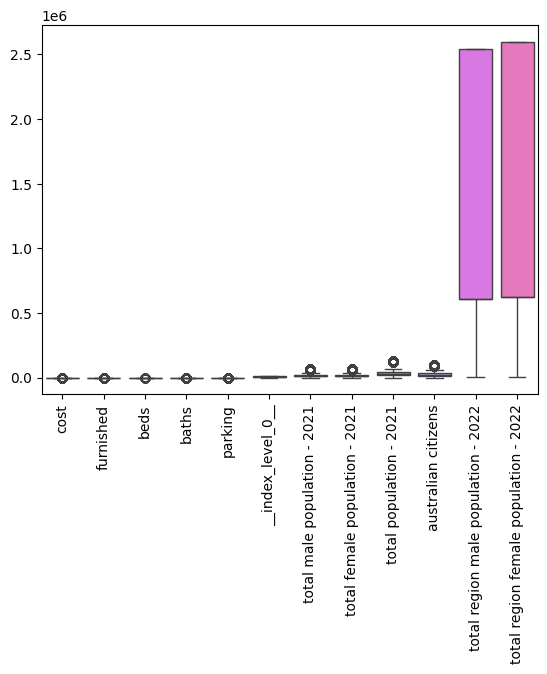

In [4]:
import seaborn as sns
pdf_numeric = pdf.drop('postcode', axis=1)
ax = sns.boxplot(data=pdf_numeric)
ax.tick_params(axis='x', labelrotation=90)

In [5]:
pdf_numeric

,cost,suburb,furnished,property_type,beds,baths,parking,__index_level_0__,region,lgaregion,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,total region male population - 2022,total region female population - 2022
0,6.131226,south-yarra,0,Apartment / Unit / Flat,1.0,1.0,1,0,Major Cities of Australia,Melbourne,11881,13149,25028,18039,2538968.0,2598457.0
1,6.131226,south-yarra,0,Apartment / Unit / Flat,1.0,1.0,1,0,Major Cities of Australia,Melbourne,11881,13149,25028,18039,2538968.0,2598457.0
2,6.131226,south-yarra,0,Apartment / Unit / Flat,1.0,1.0,1,0,Major Cities of Australia,Melbourne,11881,13149,25028,18039,2538968.0,2598457.0
3,5.736572,burwood,0,Apartment / Unit / Flat,1.0,1.0,0,1,Major Cities of Australia,Monash,7279,7872,15147,10527,2538968.0,2598457.0
4,5.736572,burwood,0,Apartment / Unit / Flat,1.0,1.0,0,1,Major Cities of Australia,Monash,7279,7872,15147,10527,2538968.0,2598457.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54195,6.263398,oak-park,0,Townhouse,2.0,2.0,1,11978,Major Cities of Australia,Moreland,18287,18483,36772,27661,2538968.0,2598457.0
54196,6.326149,melbourne,1,Apartment / Unit / Flat,1.0,1.0,0,11979,Major Cities of Australia,Melbourne,21548,21539,43084,14713,2538968.0,2598457.0
54197,6.396930,footscray,0,Apartment / Unit / Flat,2.0,2.0,1,11980,Major Cities of Australia,Maribyrnong,11361,10913,22278,16807,2538968.0,2598457.0
54198,6.396930,footscray,0,Apartment / Unit / Flat,2.0,2.0,1,11980,Major Cities of Australia,Maribyrnong,11361,10913,22278,16807,2538968.0,2598457.0


<Axes: >

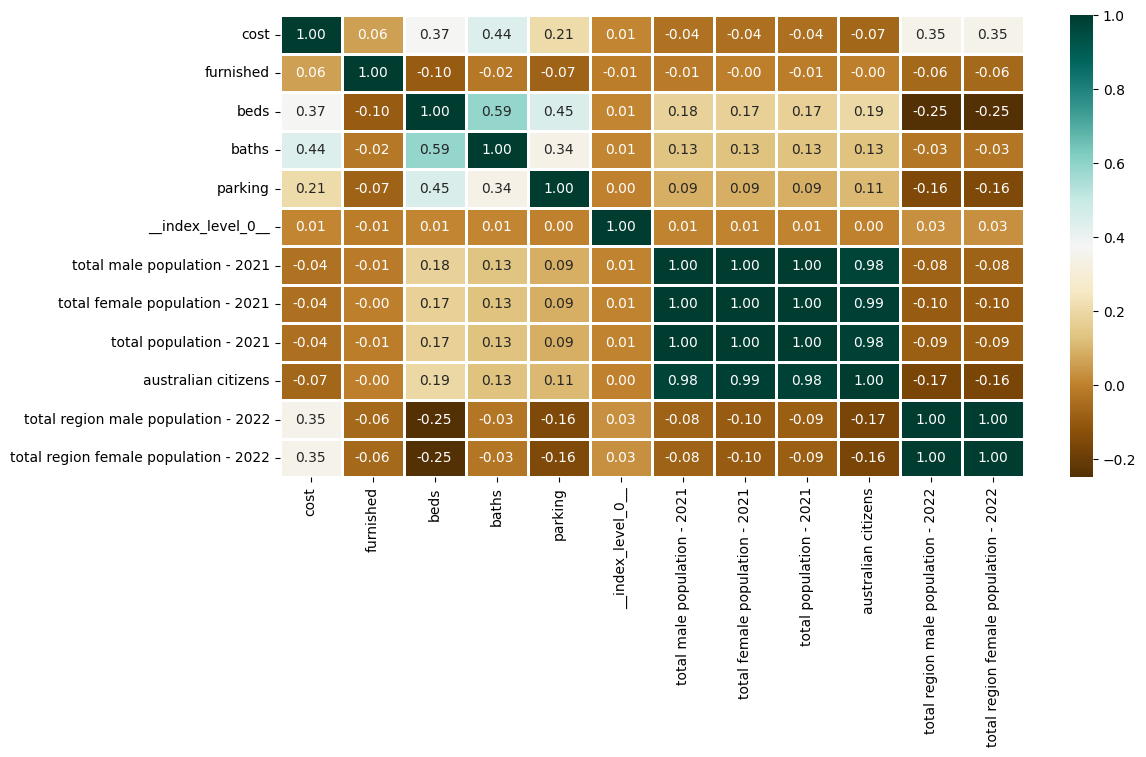

In [6]:
import matplotlib.pyplot as plt
pdf_numeric = pdf_numeric.drop(['suburb', 'property_type', 'region', 'lgaregion'], axis=1)
plt.figure(figsize=(12, 6))
sns.heatmap(pdf_numeric.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

In [7]:
pdf_numeric

,cost,furnished,beds,baths,parking,__index_level_0__,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,total region male population - 2022,total region female population - 2022
0,6.131226,0,1.0,1.0,1,0,11881,13149,25028,18039,2538968.0,2598457.0
1,6.131226,0,1.0,1.0,1,0,11881,13149,25028,18039,2538968.0,2598457.0
2,6.131226,0,1.0,1.0,1,0,11881,13149,25028,18039,2538968.0,2598457.0
3,5.736572,0,1.0,1.0,0,1,7279,7872,15147,10527,2538968.0,2598457.0
4,5.736572,0,1.0,1.0,0,1,7279,7872,15147,10527,2538968.0,2598457.0
...,...,...,...,...,...,...,...,...,...,...,...,...
54195,6.263398,0,2.0,2.0,1,11978,18287,18483,36772,27661,2538968.0,2598457.0
54196,6.326149,1,1.0,1.0,0,11979,21548,21539,43084,14713,2538968.0,2598457.0
54197,6.396930,0,2.0,2.0,1,11980,11361,10913,22278,16807,2538968.0,2598457.0
54198,6.396930,0,2.0,2.0,1,11980,11361,10913,22278,16807,2538968.0,2598457.0


In [8]:
# # stratified sampling --

In [9]:
pdf

,postcode,cost,suburb,furnished,property_type,beds,baths,parking,__index_level_0__,region,lgaregion,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,total region male population - 2022,total region female population - 2022
0,3141,6.131226,south-yarra,0,Apartment / Unit / Flat,1.0,1.0,1,0,Major Cities of Australia,Melbourne,11881,13149,25028,18039,2538968.0,2598457.0
1,3141,6.131226,south-yarra,0,Apartment / Unit / Flat,1.0,1.0,1,0,Major Cities of Australia,Melbourne,11881,13149,25028,18039,2538968.0,2598457.0
2,3141,6.131226,south-yarra,0,Apartment / Unit / Flat,1.0,1.0,1,0,Major Cities of Australia,Melbourne,11881,13149,25028,18039,2538968.0,2598457.0
3,3125,5.736572,burwood,0,Apartment / Unit / Flat,1.0,1.0,0,1,Major Cities of Australia,Monash,7279,7872,15147,10527,2538968.0,2598457.0
4,3125,5.736572,burwood,0,Apartment / Unit / Flat,1.0,1.0,0,1,Major Cities of Australia,Monash,7279,7872,15147,10527,2538968.0,2598457.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54195,3046,6.263398,oak-park,0,Townhouse,2.0,2.0,1,11978,Major Cities of Australia,Moreland,18287,18483,36772,27661,2538968.0,2598457.0
54196,3000,6.326149,melbourne,1,Apartment / Unit / Flat,1.0,1.0,0,11979,Major Cities of Australia,Melbourne,21548,21539,43084,14713,2538968.0,2598457.0
54197,3011,6.396930,footscray,0,Apartment / Unit / Flat,2.0,2.0,1,11980,Major Cities of Australia,Maribyrnong,11361,10913,22278,16807,2538968.0,2598457.0
54198,3011,6.396930,footscray,0,Apartment / Unit / Flat,2.0,2.0,1,11980,Major Cities of Australia,Maribyrnong,11361,10913,22278,16807,2538968.0,2598457.0


In [10]:
suburbs = pdf.groupby(['postcode'])[['cost', 'beds','baths', 'parking', 'furnished', 
                                     'total male population - 2021', 'total female population - 2021',
                                     'total population - 2021', 'australian citizens', 'total region male population - 2022',
                                     'total region female population - 2022']].mean()
suburbs = suburbs.round()
suburbs[0:10]

,cost,beds,baths,parking,furnished,total male population - 2021,total female population - 2021,total population - 2021,australian citizens,total region male population - 2022,total region female population - 2022
postcode,,,,,,,,,,,
3000,6.0,2.0,1.0,0.0,0.0,21548.0,21539.0,43084.0,14713.0,2538968.0,2598457.0
3002,7.0,2.0,1.0,1.0,0.0,2353.0,2545.0,4896.0,4045.0,2538968.0,2598457.0
3003,7.0,2.0,1.0,1.0,0.0,4093.0,3926.0,8025.0,4366.0,2538968.0,2598457.0
3004,6.0,2.0,1.0,1.0,0.0,5655.0,5827.0,11482.0,7103.0,2538968.0,2598457.0
3006,7.0,2.0,1.0,1.0,0.0,11499.0,11197.0,22699.0,11460.0,2538968.0,2598457.0
3008,7.0,2.0,1.0,1.0,0.0,8037.0,7458.0,15495.0,6983.0,2538968.0,2598457.0
3011,6.0,2.0,1.0,1.0,0.0,11361.0,10913.0,22278.0,16807.0,2538968.0,2598457.0
3012,6.0,2.0,2.0,1.0,0.0,13593.0,13423.0,27023.0,21594.0,2538968.0,2598457.0
3013,6.0,3.0,1.0,1.0,0.0,7603.0,8038.0,15636.0,13764.0,2538968.0,2598457.0


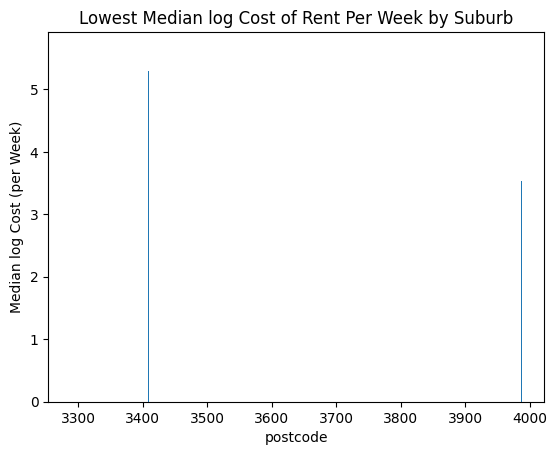

In [11]:
medians = pdf.groupby(["postcode"])["cost"].median() 

import pandas as pd
median_pdf = pd.DataFrame(medians)
median_pdf = median_pdf.sort_values(by=['cost'])

# Importing required libraries 
import matplotlib.pyplot as plt 

# creating the bar plot
plt.bar(list(median_pdf[0:10].index), median_pdf['cost'][0:10]) # fix x label, fix outliers, data check

plt.xlabel("postcode")
plt.ylabel("Median log Cost (per Week)")
plt.title("Lowest Median log Cost of Rent Per Week by Suburb")
plt.show()

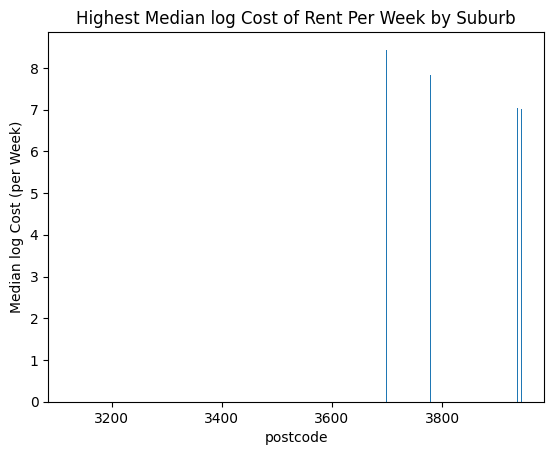

In [12]:
medians = pdf.groupby(["postcode"])["cost"].median() 

import pandas as pd
median_pdf = pd.DataFrame(medians)
median_pdf = median_pdf.sort_values(by=['cost'], ascending = False)

# Importing required libraries 
import matplotlib.pyplot as plt 

#fig = plt.figure(figsize = (7, 4))

# creating the bar plot
plt.bar(list(median_pdf[0:10].index), median_pdf['cost'][0:10]) # fix x label, fix outliers, data check

plt.xlabel("postcode")
plt.ylabel("Median log Cost (per Week)")
plt.title("Highest Median log Cost of Rent Per Week by Suburb")
plt.show()

In [13]:
maxValues = pdf['cost'].max(skipna=True)
maxValues

np.float64(11.461632170582678)

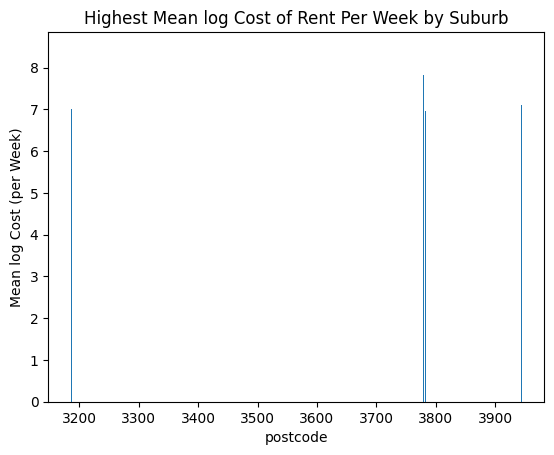

In [14]:
means = pdf.groupby(["postcode"])["cost"].mean() 

import pandas as pd
means_pdf = pd.DataFrame(means)
means_pdf = means_pdf.sort_values(by=['cost'], ascending = False)

# Importing required libraries 
import matplotlib.pyplot as plt 

# creating the bar plot
plt.bar(list(means_pdf[0:10].index), means_pdf['cost'][0:10]) # fix x label, fix outliers, data check

plt.xlabel("postcode")
plt.ylabel("Mean log Cost (per Week)")
plt.title("Highest Mean log Cost of Rent Per Week by Suburb")
plt.show()

# Scatterplots - sample

In [15]:
means_pdf

,cost
postcode,
3699,8.431220
3779,7.824046
3428,7.495542
3331,7.150701
3944,7.102112
...,...
3393,5.393628
3409,5.298317
3737,4.680175


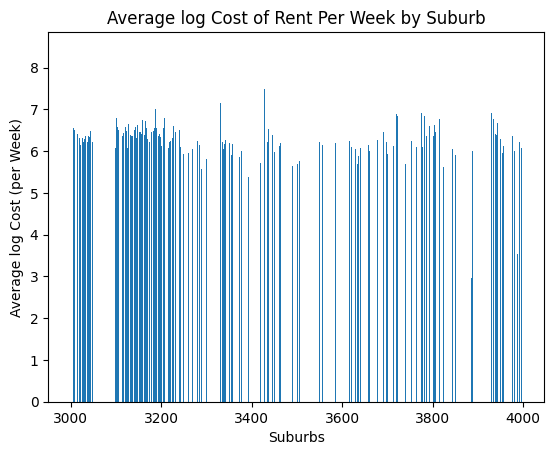

In [16]:
# Importing required libraries 
import matplotlib.pyplot as plt 

# creating the bar plot
plt.bar(list(means_pdf.index), means_pdf['cost']) # can input top 10 indices

plt.xlabel("Suburbs")
plt.ylabel("Average log Cost (per Week)")
plt.title("Average log Cost of Rent Per Week by Suburb")
plt.show()

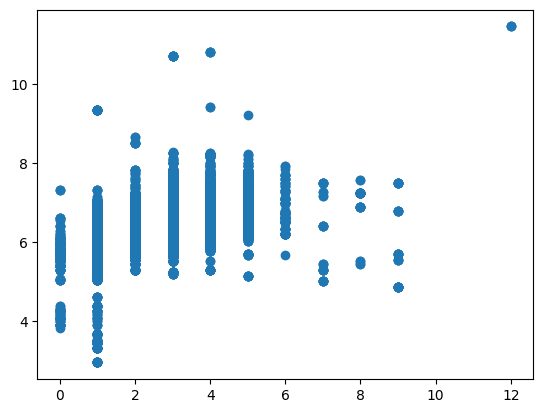

In [17]:
import matplotlib.pyplot as plt

plt.scatter(pdf['beds'], pdf['cost'])
plt.show()

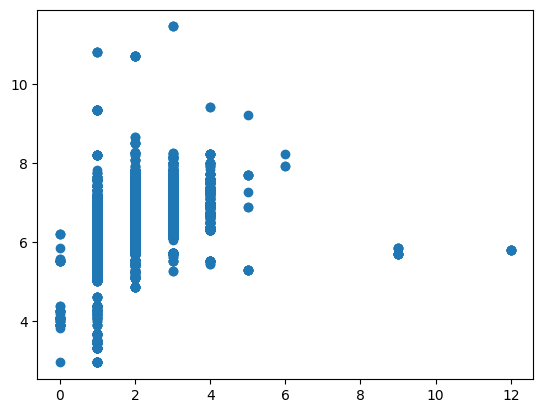

In [18]:
import matplotlib.pyplot as plt

plt.scatter(pdf['baths'], pdf['cost'])
plt.show()

Regression


In [19]:
from sklearn.model_selection import train_test_split

# Label
y = pdf_numeric['cost']

# Predictors
x = pdf_numeric.drop(['cost'], axis=1)

# Create train, test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=10)

In [20]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test , y_test)

0.4088101656353845

In [21]:
#K fold cross validation

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

#Randomize the sample so each of the fold has equal distribution of data samples
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0) # do hyperparameter tuning

cross_val_score(LinearRegression(), x, y, cv=cv)

array([0.46308595, 0.43898296, 0.42135976, 0.4378283 , 0.42799131])

In [23]:
# Linear Regression

from sklearn import datasets, linear_model, metrics
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [24]:
# regression coefficients
print('Coefficients: ', reg.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test))) # not v good

Coefficients:  [ 2.49922115e-01  1.36991099e-01  1.49328656e-01  2.37884270e-02
 -8.98246661e-07  2.87562922e-03  3.01752562e-03 -2.93779531e-03
 -1.32562087e-05  9.34961178e-06 -8.96916022e-06]
Variance score: 0.4088101656353845


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
 
# Create a random forest regression model
model = RandomForestRegressor(n_estimators=100)
 
# Fit the model to the data
model.fit(x, y)
 
# Predict the response for a new data point
y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

print("R2 Score:", r2)

# Make predictions

print("Prediction:", y_pred)

Mean Squared Error: 0.000554997323506813
Mean Absolute Error: 0.006039291302987019
R2 Score: 0.9964902511161483
Prediction: [6.37569487 6.30991828 6.39692966 ... 6.37029394 6.55108034 6.04025471]


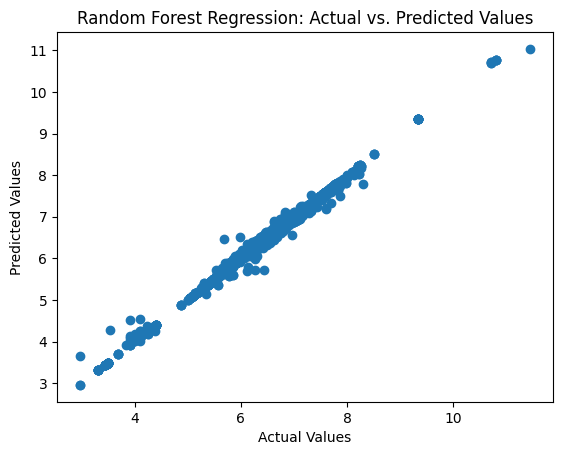

In [26]:
plt.scatter(y_test, y_pred) # sample?
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Regression: Actual vs. Predicted Values")
plt.show() # Much better performance  

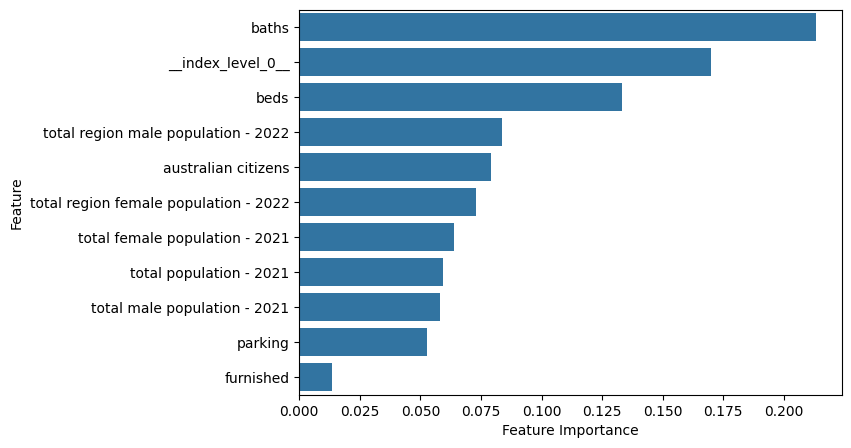

In [27]:
rf_feature_importances = model.feature_importances_
rf_feature_importances = pd.Series(
    rf_feature_importances, index=X_train.columns.values
    ).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(x=rf_feature_importances, y=rf_feature_importances.index)
plt.xlabel('Feature Importance');
plt.ylabel('Feature');

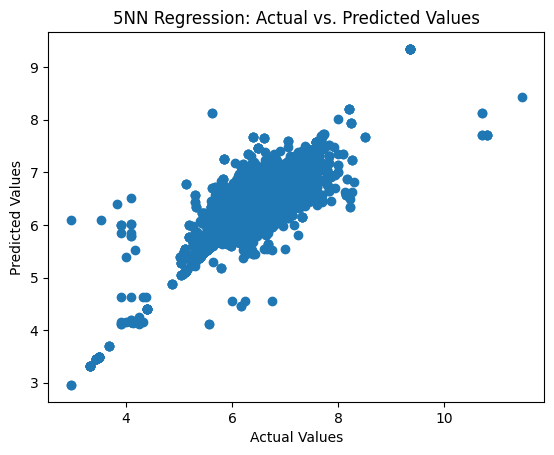

Score for k=1: 0.6822397585227578
Score for k=2: 0.6822397585227578
Score for k=3: 0.6822397585227578
Score for k=4: 0.6822397585227578
Score for k=5: 0.6822397585227578
Score for k=6: 0.6822397585227578
Score for k=7: 0.6822397585227578
Score for k=8: 0.6822397585227578
Score for k=9: 0.6822397585227578
Score: 0.6822397585227578


In [28]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors=5) # find optimal value
knn_regressor.fit(X_train, y_train)
predictions = knn_regressor.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("5NN Regression: Actual vs. Predicted Values")
plt.show() # Much better performance
# Need to pick optimal K

for k in range(1, 10):
    knn_regressor = KNeighborsRegressor(n_neighbors=5)
    knn_regressor.fit(X_train, y_train)
    print(f'Score for k={k}: {knn_regressor.score(X_test, y_test)}')

# Evaluate the model
print('Score:', knn_regressor.score(X_test, y_test)) # The score() method gives us the coefficient of determination R^2 of the prediction


In [29]:
import numpy as np
from glmnet import ElasticNet


# LASSO Model
elastic_net_model = ElasticNet(alpha=1) 
elastic_net_model.fit(x,y)

ElasticNet()

In [30]:
# Lambda Value
print(f'Best lambda value for LASSO: {elastic_net_model.lambda_best_[0]}')

Best lambda value for LASSO: 0.0006425990486066676


In [31]:
y_pred = elastic_net_model.predict(X_test)

# Import necessary libraries
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
import numpy as np
import matplotlib.pyplot as plt

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
# Print the model coefficients
print("Elastic Net Coefficients:")
print(elastic_net_model.coef_)
# Print the model intercept
print("Elastic Net Intercept:")
print(elastic_net_model.intercept_)
r2_score(y_test,y_pred)

Mean Squared Error: 0.09452187725028824
Elastic Net Coefficients:
[ 2.63822665e-01  1.28195186e-01  1.52770645e-01  2.07528718e-02
 -8.54937361e-07 -2.02315870e-05  2.39474192e-05  0.00000000e+00
 -4.14826884e-06  1.60289185e-07  7.61838374e-09]
Elastic Net Intercept:
5.416454361612528


0.40225287739664406

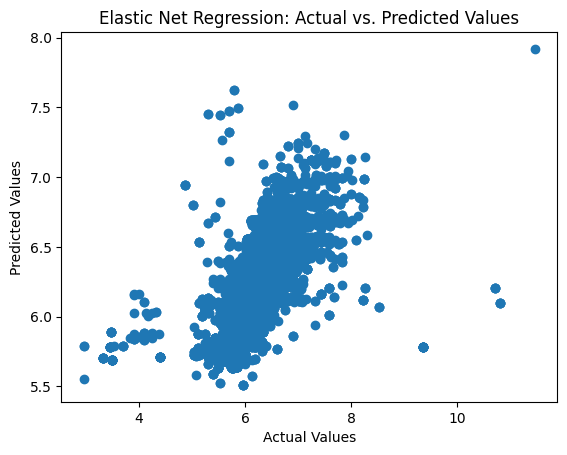

In [32]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Elastic Net Regression: Actual vs. Predicted Values")
plt.show()

In [33]:
# Begin forecasting the rental properties for the next 3-years by suburb or any other suitable
# granularity (we will let groups decide on the granularity). Whilst working on this, groups are
# expected to also present some analysis on what features are useful in making a certain suburb
# more expensive and sought after.

In [34]:
# Groups are to continue working on their predictions and analysis. Additionally, prepare a
# summary notebook (3-5 minutes max) and walk your Tutor through the current findings and
# any additional insights so far. This task should assist in helping groups formulate their answers
# to the 3 big questions.

In [35]:
# Summarise and output the 3-year predictions for your chosen granularity (i.e suburb or cluster
# of properties) and provide some form of an answer for the 3 big questions.